# Model Selection

The purpose of this notebook is to select a class of models to pursue further for this problem.
For this purpose we carry out an experiment to compare different types of machine learning models. The goal is to select a type of model to explore more in-depth in future experiments. 

The experiments in this notebook require the processed version of the dataset. You need to run data_preparation at least once before using this notebook.

The sections of this notebook describe:
1) Experiment Setup: The setup of the experiment. 
2) Evaluation Metrics: Discussing the metrics we use to compare models.
3) Data Loading: Loading the data we base our experiments on
4) Benchmarks: Finding a good simple comparison benchmark 
5) Simple Models: Experimenting with simple models, to find out which one works best.
6) Neural Networks: Experimenting with neural network configurations to find out which one works best.
7) Convolutional Neural Networks: Experimenting with convolutional neural network configurations to find out which one works. best. 
8) Evaluation: Comparison of all models based on the best versions determined in the respective sections.
9) Conclusion: Summary of the experiment results and other observations made. 

In [1]:
# Correct working directory. But only once. 
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

import random
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.metrics import hamming_loss
from keras.models import Sequential  # Model type to be used
from keras.layers import (
    Dense,
    Activation,
    Conv2D,
    Conv3D,
    LeakyReLU,
    Dropout,
    MaxPooling2D,
    MaxPooling3D,
    ZeroPadding2D,
    GlobalAveragePooling2D,
    Flatten
)   # Types of layer to be used in our model

from models.Majority_Guessing_Benchmark import MajorityGuessingBenchmark
from models.Random_Guessing_Benchmark import RandomGuessingBenchmark
from evaluation.evaluation_metrics import EvaluationMetrics
from data.dataset import Dataset

dataset = Dataset()

tf.compat.v1.enable_eager_execution() 

/Users/ninovationlab/Projects/AI/05-Teaching-Materials/01-ML-Example-Project


2023-01-03 14:57:21.368942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Experiment Setup
In this notebook we will compare multiple models based on their performance on the pokemon dataset. We will use the evaluation metrics discussed in Section Evaluation Metric. The following models will be compared:
1) Naive Benchmark: A naive benchmark consisting of either majority or random guessing.
2) Simple Model: A basic (non-neural network) machine learning model.
3) ANN: A standard neural network.
4) CNN: A Convolutional Neural Network.

For each of the categroy we will carry out a smaller experiment to identify the best candidate / configuration of the respective category. This experiment will be done by manual exploration. The best version of each category will be compared against each other. 

The models are compared based on the same train/test split (be aware that it resets every time you run this notebook) but are not fixed to a random seed. This enables us to keep things comparable but to observe statistical variations stemming from randomness during the learning process. 


## Evaluation Metrics:

The problem we want to solve is a multilabel classification problem: Each pokemon is assigned one or more types. Some elaborations on this type of problem and the applicable evaluation metrics can be found [here](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff). For comparing models, we have identified the following metrics:

### Subset Accuracy = $\frac{1}{n}\sum_{i=1}^{n} I(Y_{true,i} = Y_{pred,i})$ 

This accuracy score counts all samples for which the predicted value $Y_{true,i}$ is the same as the expected value $Y_{pred,i}$ ($I$ turns the boolean comparison result into an integer with 1 being true and 0 being false). This metric is very strict. It does not distinguish between a completely wrong or partially wrong missclassification. 

### Hamming Score = $\frac{1}{n} \sum_{i=1}^{n} \frac{|Y_{true,i} \bigcap Y_{pred,i} |}{|Y_{true,i} \bigcup Y_{pred,i} |}$

This score is more fine-grained than the subset accuracy. It is perfect, if the predicted value $Y_{pred,i}$ is the same as $Y_{true,i}$ (the $\bigcap$ and $\bigcup$ operators are pairwise comparison of the labels and are the same if all labels are the same.) it gets smaller if there are wrong guesses or labels that haven't been recognized. There is also a hamming loss operation which operates after similar principles.


### F1 Score 

The F1 score is applicable to binary classification. Since we have a multilabel classification problem, we can't apply it directly. However, we can apply it to each pokemon type exclusively. This will give us the ability to understand which classes are easy and which classes are hard for the model to detect. More details on how to apply F1 scores to multilabel problems can be found [here](https://www.baeldung.com/cs/multi-class-f1-score)

### Summary

For this experiment we will use the Hamming Score as main comparison criteria over the subset accuracy as we want partially right answers to positively influence our score. 
We will record both subset accuracy and F1 scores as well to get more data to make observations from.

These metrics are calculated in the class EvaluationMetrics.  This class enables us to calculate all metrics based on a prediction and bundle them for comparison. It also provides a function for printing them to command line for manual inspection.



## Data Loading

Let's load our data and split it in training and test data. This cell assumes that the data preparation has already been done and store via the Dataset class.

The input requirements for some of our models are different. Our data is currenty optimized around CNNs, which require a three-dimensional matrix. Our other models will require vectors. For this reason, we also prepare *X_train_flat* and *X_test_flat*, which are reshaped versions of the original dataset to fit these models.

For the CNN we will also use a different feature vector for training with the softmax function. We prepare the dataset y_train_prob appropriately.

Note that we didn't use a seed for the train test split on purpose. If you rerun this notebook you will get different results. This is on purpose to enable us to double-check our conclusions on different splits. For the experiments reported un underneith, we have run this cell only once so we can use the same train/test split for comparison purposes.

In [2]:
X, y = dataset.get_prepared_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_flat = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3]) # type: ignore
X_test_flat = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3])   # type: ignore

y_train_prob = np.array([y_train[i] for i in range(len(y_train))])

## Benchmarks

Two simple benchmarks are possible for this problem:
* Random Guessing: Guesses a random class for each pokemon (and only one)
* Majority Class Guessing: Always Guesses the Majority class "Water (identified in data_exploration.ipynb)

In the following cells, we run the models and save/print the results on the test set. Since these models are not actually learning anything we are not concerned with overfitting and thus omit the results on the training set. 

In [3]:
model = RandomGuessingBenchmark(dataset.get_labels())
y_pred_test = model.predict(X=X_test)   # type: ignore
random_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test) # type: ignore

random_test_metrics.print_evaluation_report(test_description="Random Guessing - Test Set")


Random Guessing - Test Set
- subset accuracy: 2 %
- hamming score 0.05
- f1-scores:  [0.         0.         0.         0.23529412 0.11111111 0.1
 0.         0.0952381  0.         0.06666667 0.08333333 0.11111111
 0.         0.08695652 0.         0.08       0.         0.05128205]


In [4]:
model = MajorityGuessingBenchmark(dataset.get_labels(), "Water")
y_pred_test = model.predict(X=X_test) # type: ignore
majority_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)  # type: ignore

majority_test_metrics.print_evaluation_report(test_description="Majority Guessing - Test Set")


Majority Guessing - Test Set
- subset accuracy: 7 %
- hamming score 0.12
- f1-scores:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.27659574]


Comparing both benchmarks, we notice that majority class guessing usually performs better than random guessing. It reached a hamming score of 0.12. We will thus use majority guessing as the best representation of a benchmark model. 

## Simple Model
Here we test simple models on their performance for our data set.
To identify simple models that could be applicable we referred to the [Scikit-Learn Documentation ](https://scikit-learn.org/stable/modules/multiclass.html). We have tested all models capable of multiclass and multioutput classification. Ridge Classifiers were not listed  in this category but are also applicable.

Experimantation in this cell is done by hand by testing out different models with different hyper-parameter settings. During the experiment, observations are recorded below the cell.

In [5]:
model = DecisionTreeClassifier() # depth = 10
# model = KNeighborsClassifier(n_neighbors = 3)
# model = RandomForestClassifier(max_depth=10)
# model = RidgeClassifier()
# model = RadiusNeighborsClassifier(radius = 70)
# model = ExtraTreeClassifier()

model.fit(X=X_train_flat, y=y_train)

y_pred_train = model.predict(X=X_train_flat)
simple_test_metrics = EvaluationMetrics(y_true=y_train, y_pred=y_pred_train)   # type: ignore
simple_test_metrics.print_evaluation_report(test_description="Simple Classifier - Training Set")

y_pred_test = model.predict(X=X_test_flat)
simple_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test) # type: ignore
simple_test_metrics.print_evaluation_report(test_description="Simple Classifier - Test Set")


Simple Classifier - Training Set
- subset accuracy: 100 %
- hamming score 1.0
- f1-scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Simple Classifier - Test Set
- subset accuracy: 2 %
- hamming score 0.11
- f1-scores:  [0.0625     0.16       0.28571429 0.11111111 0.         0.
 0.19354839 0.24390244 0.08       0.42857143 0.12903226 0.
 0.12903226 0.11428571 0.22222222 0.07142857 0.11764706 0.17777778]


### Experiment Notes
During the experiment the following observations were recorded:
- **Decision Trees**: Without any restrictions, a Decision Tree Classifier has managed to get perfect scores on the training set. On the test set, it exhibits an accuracy of around 9% and a hamming sore of around 0.14.To limit this obvious overfitting, we tried to experiment with the parameters *max_depth*, *min_samples_split* and *min_samples_leaf*. Using these parameters, it is possible to reduce the training scores, but the test scores did not improve  in our tests. During testing, we also noticed that the results are not very stable. They vary with reruns of the model on the sama datset.  In our tests they lie usually between accuracies of 7% and 10%  hamming scores of 0.1 and 0.15 a
- **Extra Tree Classifier**: Behaved similarly to the Decision Tree Classifier. The scores achieved on the test set were consistently below those seen in decision tree classifiers. 
- **Random Forest Classifier**: Random Forest Classifiers had a hard time classifying the test set. They seem to have overfit worse than decision trees and achieved zero scores on the test set even for low numbers of depths. Testing with different traing/test splits did not change this in our experiments. 
- **K Neighbors**: This classifier was tested with different numbers of neighbors and performed best with 3 neighbors. It achieves an accuracy of 4% and a hamming score of 0.06
- **Radius Neighbors Classifier**: To use this classifier for the test set, the radius had to be increased quite a lot (Otherwise, it wouldn't find a result). With this huge radius the performance on the training set is close to zero and zero on the training set.
- **Ridge Classifier**: The linear model ridge classifier achieved perfect scores on the training set and an accuracy of 3% and a hamming score of 0.1 on the test set. 

### Results

Based on our tests, the Decision Tree Classifier produced the best results with a hamming sore of around 0.15 and will be used as benachmark for a simple model for this test.

As stated above, this number is on the high end for this model and may be lower if re-run. However, since we expect this model to be outperformed by the other ones, we will use 0.15 for comparison for now and potentially revisit this with a more statistically sound recording of multiple runs in case we need to get more fine-grained numbers.

It should be noted that Ridge Classifiers achieved Hamming scores almost as good as te Decision Tree classifier. Should our experiments with Neural Networks fail, we would consider this classifier as a possible candidate as well. 


## Neural Networks
Here we test artificial neural networks on our pokemon classification. These networks are applied to the flattened version of the dataset. 

### Training Configuration

To find a suitable training setup we carried out some preliminary experiments with different configurations. As a result we arrived at a reasonable training setup that will be used for the actual experiments. The design decisions made are reported here.

To make neural networks compatible with our loss function we used a sigmoid activation function for the output layer in combination with binary crossentropy as loss metric. This essentially re-interprets the problem as a classification problem with 18 outputs and applies binary crossentropy to each. We also experimented with the softmax function as activation function (still combined with binary crossentropy) in the hope that it would cope better with the sparse class vector. While this function didn't perform better than sigmoid in our tests, it also did not perform significantly worse. 

During initial experimentation we identified the following information relevant to the training configuration:
- Neural Networks perform significantly better on inverted images. Our assumption is that this is due to the fact that the background, which is meaningless to our problem, is associated with a (0,0,0) value in this version. The data preparation notebook was updated accordingly and now reflects this preprocessing step. Experiments on the simple and benchmark model have been rerun with the adjusted dataset. 
- Initial experiments showed overfitting issues. In all experiments, the test loss diverged from the traning loss eventually. The exact epoch depended on the size of the model and the loss function. For this reason, it was decided to implement an early stopping callback that stops the traning process if no improvement on the test score has been achieved for five epochs. In this case, the configuration with the best validation loss is restored. 
- It was noted that a classification threshold of 0.15 leads to the best interpretation of the classification results, likely due to the high sparsity of the label vectors. 


### Experiment Procedure
To find a good network configuration we used the following manual procedure in which we run the below cell and record the results to make design decisions on what to explore next. This procedure was mainly based on personal judgement but followed the following loose procedure:
- Only the hamming score on the test set was considered during making decisions.
- The initial tested configuration was a network with one hidden layer of 100 neurons.
- We explored the influence of increasing neuron size, adding layers.
- We test different transfer functions (tanh, relu, leaky relu). These tests are performed initially - to identify which one works best - and sporadically when the network structure has changes sufficiently that we think another function may be able to perform better.
- We gave a maximum of ten minutes for a training run. If the training was not finished by that time we stop it.
- For each run we record the tested configuration, training accuracy and hamming score, test accuracy and hamming score, training epochs, training time. An optional comment is kept to preserve notes made during training

2023-01-03 14:57:38.780725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
21/21 [==============================] - 13s 602ms/step - loss: 0.3964 - val_loss: 0.3115
Epoch 2/100
21/21 [==============================] - 13s 599ms/step - loss: 0.2828 - val_loss: 0.2815
Epoch 3/100
21/21 [==============================] - 13s 599ms/step - loss: 0.2637 - val_loss: 0.2849
Epoch 4/100
21/21 [==============================] - 13s 603ms/step - loss: 0.2487 - val_loss: 0.2822
Epoch 5/100
21/21 [==============================] - 13s 609ms/step - loss: 0.2367 - val_loss: 0.2789
Epoch 6/100
21/21 [==============================] - 13s 613ms/step - loss: 0.2212 - val_loss: 0.2752
Epoch 7/100
21/21 [==============================] - 13s 604ms/step - loss: 0.2056 - val_loss: 0.2821
Epoch 8/100
21/21 [==============================] - 13s 627ms/step - loss: 0.1873 - val_loss: 0.2816
Epoch 9/100
21/21 [==============================] - 14s 641ms/step - loss: 0.1720 - val_loss: 0.2837
Epoch 10/100
21/21 [==============================] - 13s 620ms/step - loss: 0.153

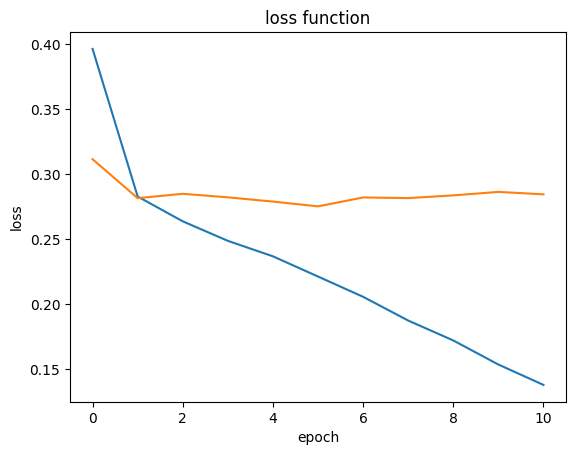

Stopped training after 11, epochs!
21/21 [==============================] - 1s 26ms/step

Artificial Neural Network - Training Set
- subset accuracy: 9 %
- hamming score 0.36
- f1-scores:  [0.44444444 0.06060606 0.52525253 0.54545455 0.38461538 0.74666667
 0.54666667 0.51470588 0.43835616 0.69512195 0.58585859 0.21428571
 0.58914729 0.49315068 0.37060703 0.14814815 0.5        0.40262582]
6/6 [==============================] - 0s 24ms/step

Artificial Neural Network - Test Set
- subset accuracy: 1 %
- hamming score 0.16
- f1-scores:  [0.25316456 0.         0.30769231 0.         0.         0.
 0.4        0.32432432 0.16       0.05714286 0.28571429 0.
 0.26229508 0.         0.19178082 0.         0.         0.38596491]


In [6]:
# Model initialization
model = Sequential()

model.add(Dense(units=1000, input_shape=(X_train_flat.shape[1],))) 
model.add(Activation(activation="tanh"))


model.add(Dense(y_train.shape[1]))  # type: ignore
model.add(Activation(activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", run_eagerly=True)


# Train mode
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,restore_best_weights=True)
history = model.fit(x=X_train_flat, y=y_train, epochs=100, validation_data=(X_test_flat, y_test), callbacks=[early_stopping])

# plot training history
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("loss function")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Plot training results
print(f"Stopped training after {len(history.epoch)}, epochs!")

y_pred = model.predict(x=X_train_flat) > 0.15
ann_train_metrics = EvaluationMetrics(y_true=y_train, y_pred=y_pred)   # type: ignore
ann_train_metrics.print_evaluation_report(test_description="Artificial Neural Network - Training Set")

y_pred_test = model.predict(x=X_test_flat) > 0.15
ann_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)    # type: ignore
ann_test_metrics.print_evaluation_report(test_description="Artificial Neural Network - Test Set")

### Experiment Notes

The training values have been recorded in "evaluation/experiment_records/Model Selection - ANN - Experiment.xlsx" in Sheet "Exploration Results". 


During the manual exploration we noted down our thoughts and findings and how they influenced the process:
- On the initial configuration, $tanh$ performed best. We continued experimenting with this transfer function. 
- We tried altering the model structure to learn a more simple model (10 neurons), a more complex model (1000 neurons) and a model with multiple layers (100,100). Both the introduction of more neurons and the additional layers increased the hamming score a little. The test with ten neurons had a learning curve that was a lot smoother (most other models tended to be finished learning meaningfull relations after one to five iterations), it also had the worst hamming score. From this we identified two avenues: 1) High Complexity Models with larger numbers of neurons and layers and 2) low complexity models trying to get a better generalization by low complexity. 
- High Complexity Models: In this category we tried extending the number of neurons to 1000,2000 and 5000 in the first layer and add more layers. At 5000 Neurons the test exceeded our time limit. The best result remained the network with a single layer and 1000 neurons.
- Low Complexity Models: Testing in the low complexity area (< 100 neurons, single and multiple layers) yielded worse results than in the high complexity area.
- To double-check the selection of transfer functions, some configurations were also tested with leaky rely and relu. The result confirmed that tanh also performed best in those configurations.

Overall, the best score achieved was with two models: 
1) one layer with 1000 neurons and tanh function (0.19 hamming score)
2) two layers with 100 neurons each and tanh function (018 hamming score)

It was noted that the training usually stopped with a test loss between 027 and 0.28 and that the overall hamming scores of the tested variations are fairly close to each other. This raised some concerns about the influence of statistical variance on the previous exporation. 

### Statistical Variance

To explore the statistical variance we ran the two best configurations ten time and recorded the results. They can be found in the same table in sheet "Variance Test". 
The statistical values of the hamming scores of both models are as follows:
| Model| Min | Max | Mean | St. Dev |
| ---- | --- | --- | ---- | ------- |
| 1    | 0.16 | 0.19 | 0.179 | 0.009 |
| 2    | 0.14 | 0.18 | 0.155 | 0.012 |

According to these values, model 1 is the best one with a mean hamming score of 0.18. The standard deviations proofed to be around 0.01 and may well have influenced our exploration. However, since our main goal was to a pre-evaluation of neural networks, the results should still be sufficient.

### Summary

We identified a model with a single hidden layer of 1000 neurons and a tanh function to perform best for our dataset. This model reched an average score of 0.18. This will be the model we use for comparison with other models. 

As a side-note, this experiment showed that there are significiant overfitting issues. If neural networks are explored in the future, overfitting-avoidance mechanisms - such as dropout - may further increase performance.




## Convolutional Neural Networks
Here we test convolutional neural networks on our pokemon classification. These networks are applied to the original version of the dataset.

### Training Configuration

To find good training parameters, we performed a pretest by exploring different setups manually. The outcomes are:
- We noted that the softmax function (in combination with binary cross-entropy) performs significantly better than the sigmoid founction. Since this function will output a probability distribution we adjusted our test set by dividing each entry by the number of classes. This means, pokemon with 2 classes will have a 0.5 entry for each class instead of a 1. This should be compatible with the perfect outcome we would like to achieve for the softmax function.
- Initial experiments showed overfitting issues similar to neural networks. We use the same callback mechanism for early stopping in this experiment. 
- It was noted that a classification threshold of 0.1 leads to the best interpretation of the classification results, likely due to the high sparsity of the label vectors. 


### Experiment Procedure
To find a good network configuration we used the following manual procedure on the below cell:
- We optimize the hamming score on the test set. 
- We started with one convolutional layer (16 3x3 filters) and one hidden layer of 100 neurons and test different adjustments of the network complexity(more convolutional layers, more neurons, more dense layers, different filter sizes) step-wise
- We tested different transfer functions (tanh, relu, leaky relu). These tests are performed, whenever the network architecture has achieved increased results.
- Training is stopped if it exceeds ten minutes.
- For each run we record the test configuration, training accuracy and hamming score, test accuracy and hamming score, training epochs, training time. An optional comment is kept to preserve notes made during training

Epoch 1/100
21/21 [==============================] - 4s 211ms/step - loss: 0.3126 - val_loss: 0.2863
Epoch 2/100
21/21 [==============================] - 4s 202ms/step - loss: 0.2689 - val_loss: 0.2840
Epoch 3/100
21/21 [==============================] - 4s 205ms/step - loss: 0.2606 - val_loss: 0.2794
Epoch 4/100
21/21 [==============================] - 4s 205ms/step - loss: 0.2465 - val_loss: 0.2776
Epoch 5/100
21/21 [==============================] - 5s 218ms/step - loss: 0.2229 - val_loss: 0.2728
Epoch 6/100
21/21 [==============================] - 4s 205ms/step - loss: 0.1916 - val_loss: 0.2755
Epoch 7/100
21/21 [==============================] - 4s 204ms/step - loss: 0.1544 - val_loss: 0.2810
Epoch 8/100
21/21 [==============================] - 5s 215ms/step - loss: 0.1174 - val_loss: 0.2839
Epoch 9/100
21/21 [==============================] - 5s 229ms/step - loss: 0.0888 - val_loss: 0.2915
Epoch 10/100
21/21 [==============================] - 5s 233ms/step - loss: 0.0688 - val_lo

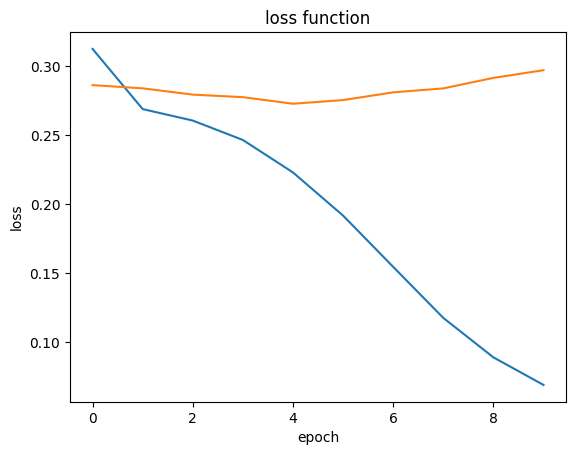

Stopped training after 10 epochs!
21/21 [==============================] - 1s 58ms/step

Convolutional Neural Network - Training Set
- subset accuracy: 29 %
- hamming score 0.56
- f1-scores:  [0.52427184 0.61538462 0.62962963 0.52830189 0.72       0.76923077
 0.6119403  0.79581152 0.66666667 0.79041916 0.66019417 0.71111111
 0.51327434 0.82568807 0.78832117 0.58666667 0.76923077 0.5       ]
6/6 [==============================] - 0s 56ms/step

Convolutional Neural Network - Test Set
- subset accuracy: 6 %
- hamming score 0.2
- f1-scores:  [0.41666667 0.         0.         0.         0.         0.
 0.37037037 0.36       0.         0.3125     0.07407407 0.28571429
 0.26506024 0.21052632 0.16       0.         0.15384615 0.40740741]


In [7]:
# Build the model
model = Sequential()

model.add(layer=Conv2D(filters=16, kernel_size=(3, 3), input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]), padding="same"))   # type: ignore          
model.add(layer=Activation(activation="tanh"))  # LeakyReLU()
model.add(layer=MaxPooling2D(pool_size=(2,2)))
model.add(layer=Flatten())       
model.add(layer=Dense(units=100))                                                 
model.add(layer=Activation(activation="tanh"))          
model.add(layer=Dense(y_train.shape[1]))    # type: ignore
model.add(layer=Activation(activation="softmax"))

model.compile(loss="binary_crossentropy", optimizer="adam", run_eagerly=True)

# Training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,restore_best_weights=True)
history = model.fit(x=X_train, y=y_train_prob, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training history
plt.plot(history.history["loss"], label='training loss')
plt.plot(history.history["val_loss"],label='validation loss')
plt.title("loss function")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Plot training results
print(f"Stopped training after {len(history.epoch)} epochs!")

y_pred = model.predict(x=X_train) > 0.1
cnn_train_metrics = EvaluationMetrics(y_true=y_train, y_pred=y_pred)   # type: ignore
cnn_train_metrics.print_evaluation_report(test_description="Convolutional Neural Network - Training Set")

y_pred_test = model.predict(x=X_test) > 0.1
cnn_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)    # type: ignore
cnn_test_metrics.print_evaluation_report(test_description="Convolutional Neural Network - Test Set")

### Experiment Notes

The training values have been recorded in "evaluation/experiment_records/Model Selection - CNN - Experiment.xlsx" in Sheet "Exploration Results". 

During the manual exploration we noted down our thoughts and findings and how they influenced the process:
1) On the initial configuration, $tanh$ performed best, but the three transfer functions are so close that differences may be caused by variance. We continue with $tanh$ but will test the other functions again  on more complex network strutures where their differences may have a larger influence.
2) We explored the effect of different filter sizes by increasing to 5x5 and 7x7 filters. This slightly dropped the hamming score from 0.22 to 0.21. While this difference may be attributed to variance, it shows that bigger filter sizes are not leading to significant improvements, while taking more training time. It was thus decided to stick with a 3x3 filter.
3) Experiments with different filter numbers for the first layer showed that bigger filter numbers (32) come with slightly decreased hamming sores. In this experiment it was also apparent that the network overfit worse than with the lower number of filters. Testing smaller numbers of filters (8 and 4) showed no significant improvement. Since we will add additional convolutional layers in the next experiments, we will stay with 16 as filter number
4) Experiments with multiple layers resulted in mixed results. The best hamming score (0.23) was achieved with two layers and 16 neurons each. Three convolutional layers tended to worsen the results. 
5) To double-check the better score with two convolutional layers we ran that configuration 2 more times. It turned out the 0.23 hamming score was a fluke. 
6) Varying the number of neurons in the fully connected layer showed that there is indeed a sweet spot around 100. Lowering the number too much (10) reduced the hamming score drastically. Increasing it too much (1000) led to worse hamming scores. It was also obvious that the model started to overfit quickly at around 500 to 1000 neurons. This is not visible in the recorded values since we record the model at the point of the best test score. in the case of 1000 neurons, the model was already close to a loss of 0 on the training set five iterations after the test and training scores diverged.
7) We tried to increase the number of fully connected layers to two and  tried out different numbers of neurons for both. at 100,100 neurons, there was already obvious quick overfitting. For lower numbers of neurons (50,50 and 50,10) the results got noticably worse. 
8) We tried  increasin complexity in the convolutional part as well as the fully connected part. All tested combinations performed worse than our best so far. 
9) To re-validate the selection of *tanh*, we also ran one model with more convolutional and fully connected layers on *relu* and *leaky relu*. Again, all functions performed siilarly. 


Sumarizing, our initial model achieved one of the best scores (altough multiple scores were close). This model had 1 convolutional layer with 16 3x3 filters and one fully connected layer with 100 neurons. It achieved a socre of 0.22 hamming loss.

Generally, all our models performed similarly well (with some exceptions). As with neural networks, we were able to observe that the best loss for the training set is similar for most models at around 0.26, dropping below 0.26 on only a few occasions. At that point, the training and test loss usually stared to diverge and the model started to overfit on the training set while achieving worse results on the test set. 


### Statistical Variance

To have comparable values, we will run our best model ten times and record statistical information about the hamming score. The resulting values have been recorded in "evaluation/experiment_records/Model Selection - CNN - Experiment.xlsx" in Sheet "Variance Tests". 

| Model| Min | Max | Mean | St. Dev |
| ---- | --- | --- | ---- | ------- |
| 1    | 0.19 | 0.23 | 0.212 | 0.013 |

According to these values, the model has a mean hamming score of 0.21. The standard deiation is 0.013, meaning a lot of the other configurations tested are within an expected deviation from this one. While this makes us unsure whether the selected configuration is indeed the best one, it suffices to identify it as a comparison candidate for this experiment.

### Summary

Summarizing, we can say that Neural Networks performed better than our simple model and our benchmark model. It beats these models by a minor margin that is nevertheless significant compared to the models own variation.

## Evaluation

Now that we have identified the best candidates for all categories, we can compare them against each other

| Model Type                   | Hamming Score |
| ---------------------------- | ------------- |
| Benchmark (Majority Class)   |   0.12        |
| Simple Model (DTC)           |   0.15        |
| Neural Network               |   0.18        |
| Convolutional Neural Network |   0.21        |

Based on these numbers we note the following:
* All machine learning models outperformed the simple benchmark - although not by much. In the case of the simple model, this is debatable as we used the maximum value we've seen for this comparison.
* Neural Networks outperformed the simple model. Considering that we recorded the maximum value for the Hamming Score of the simple model and the average values of the neural networks, this is significant. The standard deviation of the neural network scores was around 0.1, which is significantly lower than the difference in scores. 
* Convolutional Neural Networks outperformed Neural Networks. Convolutional Neural Networks outperformed Neural Networks by 0.03 in the hamming score. Considering that the standard deviation of both is around 0.1, we consider this difference in scores to be significant. 

## Summary

From comparing our results we can conclude that Convolutional Neural Networks are the best option for further optimization. We will continue exploring our dataset based on this class of models.

Furthermore, the experiments have give us some insights into the dataset and how it combines with different machine learning algorithms. These will become valuable in further experiments. We identified the following points:
* All models had significant issues with overfitting. This is likely due to the small size and big variation of the dataset, which makes it hard to learn patterns that generalize to other pokemon. It is likely that this will require changes on the dataset as well as the models. 
* Our ten minute training time restriction did not proof to stop us from exploring interesting avenues. This may indicate that the dataset can be learned with relatively low complexity models. 
* The statistical variance of learning restarts was big compared to differences between model configurations. This indicates that future experiments should always be based on statistical measures of multiple runs rather than single test runs.
* Rerunning this notebook shows that the scores achieved depend significantly on the test set. However, running the notebook multiple times showed that the CNN is still the best model in all cases. Thus, we assume the results reported transfer to other train-test splits


